# Titanic: Machine Learning from Disaster

### Import Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from jupyterthemes import jtplot
import csv
jtplot.style()
%matplotlib inline

np.random.seed(1)

## Exploratory Data Analysis and Data Cleaning

In [2]:
data = pd.read_csv('train.csv')
# test_data = pd.read_csv('test.csv')

In [3]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
#check total null values in each column
print(data.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


0    549
1    342
Name: Survived, dtype: int64

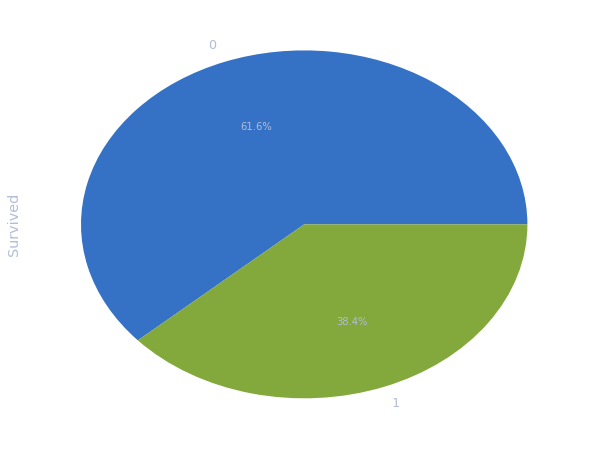

In [5]:
# plot of survival
f, ax = plt.subplots(1,figsize=(10,8))
data['Survived'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax);
data['Survived'].value_counts()

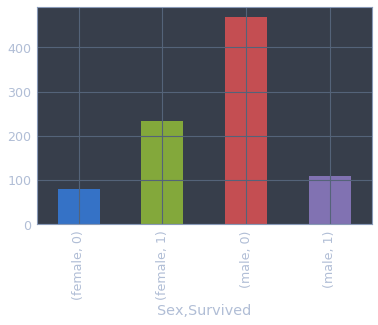

In [6]:
# see survival and sex relation
data.groupby(['Sex','Survived'])['Survived'].count().plot(kind='bar');

In [7]:
pd.crosstab(data.Pclass, data.Survived, margins=True)

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


In [8]:
pd.crosstab([data.Sex, data.Survived], data.Pclass,margins=True)

Pclass             1    2    3  All
Sex    Survived                    
female 0           3    6   72   81
       1          91   70   72  233
male   0          77   91  300  468
       1          45   17   47  109
All              216  184  491  891

In [9]:
print('Oldest Passenger was of:',data['Age'].max(),'Years')
print('Youngest Passenger was of:',data['Age'].min(),'Years')
print('Average Age on the ship:',data['Age'].mean(),'Years')

Oldest Passenger was of: 80.0 Years
Youngest Passenger was of: 0.42 Years
Average Age on the ship: 29.6991176471 Years


In [10]:
data['Initial'] = data.Name.str.extract('([A-Za-z]+)\.', expand=True)
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [11]:
data.groupby('Initial')['Name'].count()

Initial
Capt          1
Col           2
Countess      1
Don           1
Dr            7
Jonkheer      1
Lady          1
Major         2
Master       40
Miss        182
Mlle          2
Mme           1
Mr          517
Mrs         125
Ms            1
Rev           6
Sir           1
Name: Name, dtype: int64

In [12]:
# there are some errors in data, let's fix them
data['Initial'].replace(['Mlle', 'Mme', 'Ms', 'Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],['Miss', 'Miss', 'Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'], inplace=True)

In [13]:
data.groupby('Initial')['Age'].mean()

Initial
Master     4.574167
Miss      21.860000
Mr        32.739609
Mrs       35.981818
Other     45.888889
Name: Age, dtype: float64

In [14]:
## Assigning the NaN Values with the Ceil values of the mean ages
data.loc[(data.Age.isnull())&(data.Initial=='Mr'),'Age']=33
data.loc[(data.Age.isnull())&(data.Initial=='Mrs'),'Age']=36
data.loc[(data.Age.isnull())&(data.Initial=='Master'),'Age']=5
data.loc[(data.Age.isnull())&(data.Initial=='Miss'),'Age']=22
data.loc[(data.Age.isnull())&(data.Initial=='Other'),'Age']=46

In [15]:
data.Age.isnull().any() #check for nan values in age

False

In [16]:
data['Embarked'].fillna('S',inplace=True)

In [17]:
data['Age_band']=0
data.loc[data['Age']<=16,'Age_band']=0
data.loc[(data['Age']>16)&(data['Age']<=32),'Age_band']=1
data.loc[(data['Age']>32)&(data['Age']<=48),'Age_band']=2
data.loc[(data['Age']>48)&(data['Age']<=64),'Age_band']=3
data.loc[data['Age']>64,'Age_band']=4

In [18]:
data['Sex'].replace(['male','female'],[0,1],inplace=True)
data['Embarked'].replace(['S','C','Q'],[0,1,2],inplace=True)
data['Initial'].replace(['Mr','Mrs','Miss','Master','Other'],[0,1,2,3,4],inplace=True)

In [19]:
data['Age_band'].value_counts().to_frame()

,Age_band
1,382
2,325
0,104
3,69
4,11


In [20]:
data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,Age_band
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,1,1,2


## Predictive Modeling

In [21]:
train, test = train_test_split(data, test_size=0.3,random_state=0,stratify=data['Survived'])

X_train = train[['Pclass', 'Sex', 'Age_band', 'Embarked', 'Initial']].values
X_train = X_train.T.astype(float)
X_test = test[['Pclass', 'Sex', 'Age_band', 'Embarked', 'Initial']].values
X_test = X_test.T.astype(float)

Y_train = train['Survived'].values
Y_train = Y_train.reshape(1, Y_train.shape[0])

Y_test = test['Survived'].values
Y_test = Y_test.reshape(1, Y_test.shape[0])


In [22]:
print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)

(5, 623) (5, 268)
(1, 623) (1, 268)


### DNN 

In [23]:
def Initialize_parameters_deep(layer_dims):
    np.random.seed(3)
    parameters = {}
    for l in range(1, len(layer_dims)):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
    return parameters

In [24]:
def sigmoid(Z):
    return 1 / (1 + np.exp(-1 * Z))
def relu(Z):
    return np.maximum(0, Z)

In [25]:
def linear_activation_forward(A_prev, W, b, activation):
    Z = np.dot(W, A_prev) + b
    linear_cache = (A_prev, W, b)

    if activation == 'sigmoid':
        A = sigmoid(Z)
    elif activation == 'relu':
        A = relu(Z)
        
    activation_cache = Z
    cache = (linear_cache, activation_cache)
    return A, cache

In [26]:
def forward_propogation(X, parameters):
    
    A_prev = X
    L = len(parameters)//2
    caches = []
    for l in range(1, L):
        Wl = parameters['W' + str(l)]
        bl = parameters['b' + str(l)]
        A_prev, cache = linear_activation_forward(A_prev, Wl, bl, 'relu')
        caches.append(cache)

    AL, cache = linear_activation_forward(A_prev, parameters['W' + str(L)], parameters['b' + str(L)], 'sigmoid')
    caches.append(cache)
    return AL, caches


In [27]:
#np.mulliply is diff than X*Y
def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = -1 / m * np.sum((Y * np.log(AL) + ((1 - Y) * np.log(1 - AL))))
    cost = np.squeeze(cost)
    return cost


In [28]:
def sigmoid_backward(dA, activation_cache):
    Z = activation_cache
    A = sigmoid(Z)
    dZ = dA * A * (1 - A)
    return dZ

In [29]:
def relu_backward(dA, activation_cache):
    Z = activation_cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    return dZ

In [30]:
def linear_activation_backward(dA, cache, activation):
    
    linear_cache, activation_cache = cache
    
    if activation == 'sigmoid':
        dZ = sigmoid_backward(dA, activation_cache)
    elif activation == 'relu':
        dZ = relu_backward(dA, activation_cache)
        
    A_prev, W, b = linear_cache
    m = A_prev.shape[1]
    dW = 1 / m * np.dot(dZ, A_prev.T)
    db = 1 / m * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    return dA_prev, dW, db


In [31]:
def backward_propogation(AL, Y, caches):
    L = len(caches)
    grads = {}
    dAL = - np.divide(Y, AL) + np.divide(1 - Y, 1 - AL)
    grads['dA' + str(L)], grads['dW' + str(L)], grads['db' + str(L)] = linear_activation_backward(dAL, caches[L-1], 'sigmoid')
    A_prev = AL
    for l in range(L-1, 0, -1):
        cache = caches[l-1]
        dA = grads['dA' + str(l+1)]
        dA_prev, dW, db = linear_activation_backward(dA, cache, 'relu')
        grads['dA' + str(l)] = dA_prev
        grads['dW' + str(l)] = dW
        grads['db' + str(l)] = db
        
    return grads

In [32]:
def update_parameters(parameters, grads, learning_rate):
    for l in range(1, len(parameters)//2 + 1 ):
        parameters['W' + str(l)] -= learning_rate * grads['dW' + str(l)]
        parameters['b' + str(l)] -= learning_rate * grads['db' + str(l)]
    return parameters



In [33]:
def the_model(X, Y, layers_dims, learning_rate, num_iterations, print_cost=True):
    
    np.random.seed(1)
    costs = []
    
    parameters = Initialize_parameters_deep(layers_dims)
#     parameters = np.load('parameters.npy').item()
    for i in range(num_iterations+1):
        AL, caches = forward_propogation(X, parameters)
        cost = compute_cost(AL, Y)
        grads = backward_propogation(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)
        if (i%50000==0):
            print('Cost at iteration %s is %s' %(i, cost))
        if(i%10000==0):
            costs.append(cost)
            
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    np.save("parameters", parameters)
    return parameters


In [34]:
def predictAccuracy(X, Y, parameters):
    
    m = X.shape[1]
    p = np.zeros((1, m))
    probas, caches = forward_propogation(X, parameters)
    
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0, i] > 0.4:
            p[0, i] = 1
        else:
            p[0, i] = 0
    
    print("Accuracy: "  + str(np.sum((p == Y)) / m))
        
    return np.squeeze(p)

Cost at iteration 0 is 0.693225911878
Cost at iteration 50000 is 0.451380662977
Cost at iteration 100000 is 0.425283371519
Cost at iteration 150000 is 0.419366407361
Cost at iteration 200000 is 0.418461541254


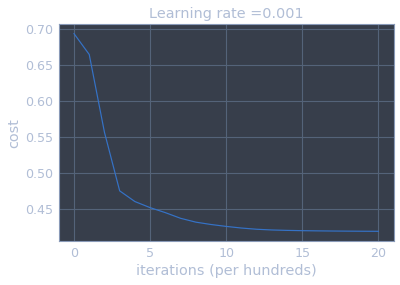

CPU times: user 59.4 s, sys: 103 ms, total: 59.5 s
Wall time: 59.4 s


In [35]:
%%time
layers_dims = [5, 10, 1]
parameters = the_model(X_train, Y_train, layers_dims, learning_rate=0.001, num_iterations=200000, print_cost=True)

In [53]:
%%time
prob = predictAccuracy(X_train, Y_train, parameters)

Accuracy: 0.786516853933
CPU times: user 0 ns, sys: 1.82 ms, total: 1.82 ms
Wall time: 920 µs


In [55]:
%%time
prob = predictAccuracy(X_test, Y_test, parameters)

Accuracy: 0.791044776119
CPU times: user 724 µs, sys: 24 µs, total: 748 µs
Wall time: 530 µs


In [56]:
np.save("parameters-v1", parameters)

## Evaluation Time!

### Test Data cleaning

In [57]:
test_data = pd.read_csv('test.csv')

In [58]:
test_data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [59]:
test_data['Initial'] = test_data.Name.str.extract('([A-Za-z]+)\.', expand=True)
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Mrs
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Mr
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,Mrs


In [60]:
test_data.groupby('Initial')['Age'].count()

Initial
Col         2
Dona        1
Dr          1
Master     17
Miss       64
Mr        183
Mrs        62
Ms          0
Rev         2
Name: Age, dtype: int64

In [61]:
test_data['Initial'].replace(['Col', 'Dona','Dr', 'Ms', 'Rev'], ['Other', 'Miss', 'Mr', 'Miss', 'Other'], inplace=True)
test_data.groupby('Initial')['Age'].count()

Initial
Master     17
Miss       65
Mr        184
Mrs        62
Other       4
Name: Age, dtype: int64

In [62]:
test_data.groupby('Initial')['Age'].mean()

Initial
Master     7.406471
Miss      22.039846
Mr        32.114130
Mrs       38.903226
Other     42.750000
Name: Age, dtype: float64

In [63]:
## Assigning the NaN Values with the Ceil values of the mean ages
test_data.loc[(test_data.Age.isnull())&(test_data.Initial=='Mr'),'Age']=33
test_data.loc[(test_data.Age.isnull())&(test_data.Initial=='Mrs'),'Age']=39
test_data.loc[(test_data.Age.isnull())&(test_data.Initial=='Master'),'Age']=7
test_data.loc[(test_data.Age.isnull())&(test_data.Initial=='Miss'),'Age']=22
test_data.loc[(test_data.Age.isnull())&(test_data.Initial=='Other'),'Age']=43

In [64]:
test_data['Age_band']=0
test_data.loc[test_data['Age']<=16,'Age_band']=0
test_data.loc[(test_data['Age']>16)&(test_data['Age']<=32),'Age_band']=1
test_data.loc[(test_data['Age']>32)&(test_data['Age']<=48),'Age_band']=2
test_data.loc[(test_data['Age']>48)&(test_data['Age']<=64),'Age_band']=3
test_data.loc[test_data['Age']>64,'Age_band']=4

In [65]:
data['Age_band'].value_counts().to_frame()

,Age_band
1,382
2,325
0,104
3,69
4,11


In [66]:
test_data['Sex'].replace(['male','female'],[0,1],inplace=True)
test_data['Embarked'].replace(['S','C','Q'],[0,1,2],inplace=True)
test_data['Initial'].replace(['Mr','Mrs','Miss','Master','Other'],[0,1,2,3,4],inplace=True)

### Run Model on Test data

In [67]:
X = test_data[['Pclass', 'Sex', 'Age_band', 'Embarked', 'Initial']].values
X = X.T.astype(float)
X.shape

(5, 418)

In [68]:
def predict(X, parameters):
    m = X.shape[1]
    p = np.zeros((1, m))
    probas, caches = forward_propogation(X, parameters)
    
    for i in range(0, probas.shape[1]):
        if probas[0, i] > 0.4:
            p[0, i] = 1
        else:
            p[0, i] = 0

    return np.squeeze(p)

In [69]:
Y = predict(X, parameters)

#### Generate csv file for submission

In [70]:
with open('submission-v1.csv', 'w') as file:
    writer = csv.writer(file)
    writer.writerow(['PassengerId', 'Survived'])
    for index, row in test_data.iterrows():
        writer.writerow([row['PassengerId'], int(Y[index])])    